In [1]:
from jax_circuits import *
from scipy.stats import unitary_group
import matplotlib.pyplot as plt

from qiskit import transpile
from qiskit.quantum_info import Operator

from penalty import *
from topology import *

key = random.PRNGKey(0)
from jax import custom_jvp, jvp, grad

from pyeasyga import pyeasyga

# Helper functions

# Genetic

In [7]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
u_toff = Operator(qc.reverse_bits()).data

In [9]:
n_q = 3
depth=14
ordered_placemenets = (sequ_layer(3)*10)[:depth]
# u_target = unitary_group.rvs(2**n_q, random_state=0)
u_target = u_toff


key = random.PRNGKey(0)
data = {'placements': ordered_placemenets}

my_ga = pyeasyga.GeneticAlgorithm(data,
                               population_size=20,
                               generations=100,
                               crossover_probability=0.8,
                               mutation_probability=0.05,
                               elitism=True,
                               maximise_fitness=True)

def create_individual(data):
    return list(np.random.randint(0, high=2, size=(len(data['placements']), )))

def individual_placemens(bitstring, data):
    all_placements = data['placements']
    placements = [all_placements[i] for i in range(len(all_placements)) if bitstring[i]]
    return placements

def individual_ansatz(bitstring, data):
    return Ansatz(n_q, 'cz', {'free': individual_placemens(bitstring, data)})

def fitness(individual, data):
    a = individual_ansatz(individual, data)
    n_gates = sum(individual)
    
    return unitary_fitness(a.unitary, u_target, a.num_angles, n_gates, n_iterations=10000, n_evaluations=10)

my_ga.fitness_function = fitness
my_ga.create_individual = create_individual

In [ ]:
%%time

my_ga.run()

In [ ]:
_, bi = my_ga.best_individual()

In [ ]:
my_ga.best_individual()

In [ ]:
print(sum(bi))
_, loss_history = individual_ansatz(bi, data).learn(u_target)
plt.plot(loss_history)
plt.yscale('log')

# Tests & benchamrks

In [2]:
@jit
def box_angles(a):
    """Bring angles within range (-pi, pi)"""
    aright = a + jnp.pi
    aright = aright % (2*jnp.pi)
    a_center = aright - jnp.pi
    return a_center

def cz_count(angles, epsilon=1e-2):
    """Count how many angles in cp gates a close to identity, CNOT and generic."""
    count = 0
    for a in angles:
        if jnp.abs(a)<epsilon:
            count += 0
        elif jnp.abs(a-jnp.pi)<epsilon or jnp.abs(a+jnp.pi)<epsilon:
            count += 1
        else:
            count +=2
            
    return count

def TLB(n):
    return int((4**n-3*n-1)/4 + 1)


def random_pair(key, num_qubits):
    key, subkey = random.split(key)
    i, j = random.randint(key, shape=(2,), minval=0, maxval=num_qubits)
    if i==j:
        return random_pair(key, num_qubits)
    else:
        return int(i), int(j)

def random_placements(key, num_qubits, num_cz):
    *keys, _ = random.split(key, num=num_cz+1)
    return [random_pair(key, num_qubits) for key in keys]        

def random_special_unitary(key, num_qubits, num_cz):
    placements = {'free': random_placements(key, num_qubits, num_cz)}
    a = Ansatz(num_qubits, 'cz', placements)
    angles = random.uniform(key, shape=(a.num_angles, ), minval=0, maxval=2*jnp.pi)
    return a.unitary(angles), placements



## Update test

In [3]:
def ff(angles):
    return jnp.cos(angles[0])+jnp.sin(angles[1])+0.01*jnp.cos(angles[1])*(0.3*jnp.cos(angles[3])-0.26*jnp.sin(angles[3]))

In [4]:
angs = jnp.array((0., 0., 0.))
mas = jnp.array(min_angles(ff, angs, 0, 3)) 

In [5]:
mas/jnp.pi

DeviceArray([1.        , 1.4990451 , 0.77269816], dtype=float32)

## 2-qubit bench

In [6]:
a = Ansatz(2, 'cz', fill_layers(sequ_layer(2), 3))
u = a.unitary
a.circuit().draw()

┌────────┐┌────────┐┌────────┐   ┌────────┐┌────────┐   ┌─────────┐»
q_0: ┤ RZ(a0) ├┤ RX(a1) ├┤ RZ(a2) ├─■─┤ RY(a6) ├┤ RX(a7) ├─■─┤ RY(a10) ├»
     ├────────┤├────────┤├────────┤ │ ├────────┤├────────┤ │ ├─────────┤»
q_1: ┤ RZ(a3) ├┤ RX(a4) ├┤ RZ(a5) ├─■─┤ RY(a8) ├┤ RX(a9) ├─■─┤ RY(a12) ├»
     └────────┘└────────┘└────────┘   └────────┘└────────┘   └─────────┘»
«     ┌─────────┐   ┌─────────┐┌─────────┐
«q_0: ┤ RX(a11) ├─■─┤ RY(a14) ├┤ RX(a15) ├
«     ├─────────┤ │ ├─────────┤├─────────┤
«q_1: ┤ RX(a13) ├─■─┤ RY(a16) ├┤ RX(a17) ├
«     └─────────┘   └─────────┘└─────────┘

In [7]:
v = unitary_group.rvs(4, random_state=0)
def d2(angles):
    return disc2(u(angles), v)

In [8]:
%%time
angles_history = staircase_min(d2, a.num_angles, n_iterations=1000)

CPU times: user 1.82 s, sys: 10.6 ms, total: 1.83 s
Wall time: 1.83 s


In [9]:
# placements = random_placements(random.PRNGKey(0), 3, 14)
a = Ansatz(3, 'cz', fill_layers(sequ_layer(3), 15))
u_target  = unitary_group.rvs(2**3, random_state=41)

In [18]:
%%time
_, d = learn_disc(a.unitary, u_target, a.num_angles, n_iterations=10000, n_evaluations=10)
d

CPU times: user 9.01 s, sys: 19.7 ms, total: 9.03 s
Wall time: 7.67 s


DeviceArray(4.673004e-05, dtype=float32)

## Min test

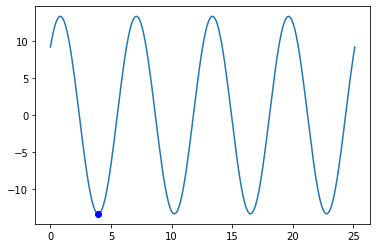

In [3]:
a, b = random.uniform(random.PRNGKey(8), shape=(2,), minval=0, maxval=10)
# a, b = 1, 0
def f(x):
    return a*jnp.cos(x)+b*jnp.sin(x)

x_sweep = jnp.linspace(0, 8*jnp.pi, 200)
plt.plot(x_sweep, vmap(f)(x_sweep))
plt.plot(min_angle(f), f(min_angle(f)), 'bo')


## Batch update

In [ ]:
def f(x):
    return x+1

def update_slice(arr, s, n, f):
    # Take a slice of array starting at 's' of length `n` and apply function 'f' to the slice.
    arr_upd = vmap(f)(lax.dynamic_slice(arr, (s, ), (n, )))
    # Return the original array with `f` applied to the slice
    return lax.dynamic_update_slice(arr, arr_upd, (s, ))


def update_all(arr, slice_size, f):
    splits = [i*slice_size for i in range(-(-len(arr)//slice_size))] # Ex: range(10) with slice_size=3 -> [0, 3, 6, 9]
    splits = jnp.array(splits)
    
    def body(i, arr):
        return update_slice(arr, splits[i], slice_size, f)
  
    arr = lax.fori_loop(0, len(splits), body, arr)

    return arr

# Shift grad test

In [10]:
a = Ansatz(5, 'cz', fill_layers(sequ_layer(5), 50))
u = a.unitary
v = unitary_group.rvs(2**5, random_state=14)
# a.circuit().draw()

In [11]:
angles = random.uniform(key, minval=0, maxval=2*jnp.pi, shape=(a.num_angles, ))

@jit
def plain_grad(angles):
    return grad(lambda a: trace2(u, v, a))(angles)

@jit
def shift_grad(angles):
    return grad(lambda a: shift_trace2(u, v, a))(angles)

In [12]:
%%time
pg = plain_grad(angles)

CPU times: user 23.5 s, sys: 26 ms, total: 23.6 s
Wall time: 23.6 s


In [13]:
%%time
sg = shift_grad(angles)

CPU times: user 6.54 s, sys: 7.71 ms, total: 6.55 s
Wall time: 6.55 s


In [14]:
jnp.allclose(pg, sg, rtol=1e-5, atol=1e-6)

DeviceArray(True, dtype=bool)

In [15]:
%timeit plain_grad(angles)

859 µs ± 2.77 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [16]:
%timeit shift_grad(angles)

59.1 ms ± 3.46 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
